# Youtube likes/view Prediction: Complete EDA + FE in One Notebook

<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Contents</h1></center>

1. [Dataset Overview](#dataset-overview)    
2. [Load Datasets](#load-datasets)  
3. [Basic Tabular EDA](#tabular-exploration-1)
4. [Feature Engineering - 1](#feature-engineering-1) 
5. [More Tabular EDA](#tabular-exploration-2)
6. [Image Exploration](#image-exploration) 
7. [Text Exploration](#text-exploration) 
8. [Feature Engineering - 2](#feature-engineering-2) 

<a id="dataset-overview"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home" id="dataset-overview">Data Overview</h1></center>

## Training/Test Data (train.parquet/test.parquet)
- id - Unique Identifier for the row (combindation of video id and trending date)
- video_id - Unique Identifier for the video
- title - Title of the Video
- publishedAt - Datetime the video was published
- channelId - Id of the channel hosting the video
- channelTitle - Title of the channel hosting the video
- categoryId - Video category
- trending_date - Date on which we are predicting the view count
- tags - Video Tags
- view_count - Number of views as of the trending date
- likes - Number of likes as of the trending date Not provided in the test set
- dislikes - Number of dislikes Not provided in the test set
- comment_count Comment Count Not provided in the test set
- thumbnail_link Link to the thumbnail of the video.
- comments_disabled True/False if comments are disabled.
- ratings_disabled True/False if ratings are disabled.
- duration_seconds The duration of the video.
- has_thumbnail True/False if the thumbnail is available for the video.
- description Video description
- target TARGET COLUMN - this is the ratio of like to view count.
the thumbnails folder contains jpg images of the thumnails for the videos when available. They can be used for training your model.

There are majorly three kinds of data in this dataset. 
1. **Tabular data** (published datetime, channelId, channel name etc)
2. **Image data** (the thumbnail image)
3. **Text data** (tags, description)

### Importing Libraries

In [1]:
!pip install transformers
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 834 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=070ab616ed8cc915e05b52e9bd708f0f15f6854f51b2acadea2830e0a1ff6497
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from PIL import Image
import glob
from transformers import ViTFeatureExtractor, ViTModel
from sentence_transformers import SentenceTransformer

<a id="load-datasets"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Loading Data</h1></center>

In [3]:
df = pd.read_parquet('../input/kaggle-pog-series-s01e01/train.parquet')
df_test = pd.read_parquet('../input/kaggle-pog-series-s01e01/test.parquet')

### Image

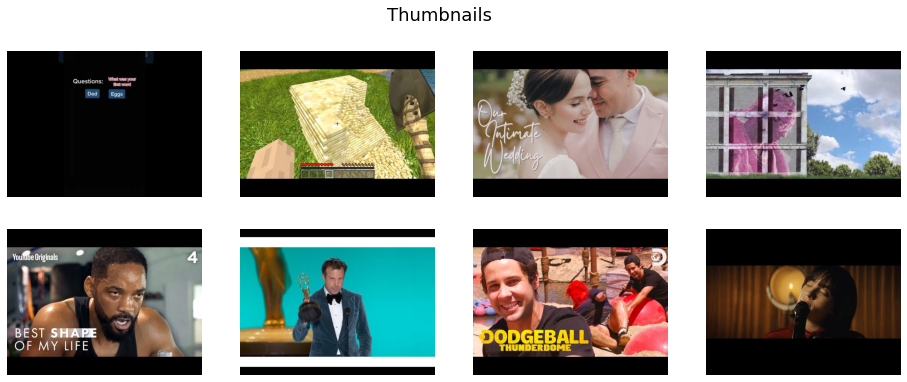

In [4]:
def get_image(folder_path, num_imgs=8):
    files = glob.glob(folder_path+'/*')
    fig, axes = plt.subplots(nrows=num_imgs//4, ncols=num_imgs//2, figsize=(16,6))
    row=0
    col=0
    plt.suptitle('Thumbnails', fontsize=18)
    for i,img_path in enumerate(files):
        image = Image.open(img_path)
        axes[row, col].imshow(image, cmap=plt.cm.bone)
        axes[row, col].axis('off')
        if (i+1)%4==0:
            row+=1
            col=0
        else:
            col+=1
        if i==num_imgs-1:
            break


get_image('../input/kaggle-pog-series-s01e01/thumbnails')

### Text

There are few text data in the table.  (See [Basic Tabular EDA](#tabular-exploration-1)) for example description, tags, title.

In [5]:
texts = [txt for i,txt in enumerate(df['title']) if i<10]
print("Titles of the videos")
print()
for i in texts:
    print(i)

Titles of the videos

I ASKED HER TO BE MY GIRLFRIEND...
Apex Legends | Stories from the Outlands – “The Endorsement”
I left youtube for a month and THIS is what happened.
XXL 2020 Freshman Class Revealed - Official Announcement
Ultimate DIY Home Movie Theater for The LaBrant Family!
I Haven't Been Honest About My Injury.. Here's THE TRUTH
OUR FIRST FAMILY INTRO!!
CGP Grey was WRONG
SURPRISING MY DAD WITH HIS DREAM TRUCK!! | Louie's Life
Ovi x Natanael Cano x Aleman x Big Soto - Vengo De Nada [Official Video]


<a id="tabular-exploration-1"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Basic Tabular EDA</h1></center>

In [6]:
df.head()

video_id                                              title  \
0  3C66w5Z0ixs                 I ASKED HER TO BE MY GIRLFRIEND...   
1  M9Pmf9AB4Mo  Apex Legends | Stories from the Outlands – “Th...   
2  J78aPJ3VyNs  I left youtube for a month and THIS is what ha...   
3  kXLn3HkpjaA  XXL 2020 Freshman Class Revealed - Official An...   
4  VIUo6yapDbc  Ultimate DIY Home Movie Theater for The LaBran...   

                publishedAt                 channelId   channelTitle  \
0 2020-08-11 19:20:14+00:00  UCvtRTOMP2TqYqu51xNrqAzg       Brawadis   
1 2020-08-11 17:00:10+00:00  UC0ZV6M2THA81QT9hrVWJG3A   Apex Legends   
2 2020-08-11 16:34:06+00:00  UCYzPXprvl5Y-Sf0g4vX-m6g  jacksepticeye   
3 2020-08-11 16:38:55+00:00  UCbg_UMjlHJg_19SZckaKajg            XXL   
4 2020-08-11 15:10:05+00:00  UCDVPcEbVLQgLZX0Rt6jo34A       Mr. Kate   

   categoryId trending_date  \
0          22    2020-08-12   
1          20    2020-08-12   
2          24    2020-08-12   
3          10    2020-08-12   
4          26    2020-08-12   

                                                tags  view_count   likes  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   
1  Apex Legends|Apex Legends characters|new Apex ...     2381688  146739   
2  jacksepticeye|funny|funny meme|memes|jacksepti...     2038853  353787   
3  xxl freshman|xxl freshmen|2020 xxl freshman|20...      496771   23251   
4  The LaBrant Family|DIY|Interior Design|Makeove...     1123889   45802   

   dislikes  comment_count                                  thumbnail_link  \
0      5855          35313  https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg   
1      2794          16549  https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg   
2      2628          40221  https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg   
3      1856           7647  https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg   
4       964           2196  https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg   

   comments_disabled  ratings_disabled  \
0              False             False   
1              False             False   
2              False             False   
3              False             False   
4              False             False   

                                         description                      id  \
0  SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...  3C66w5Z0ixs_2020-08-12   
1  While running her own modding shop, Ramya Pare...  M9Pmf9AB4Mo_2020-08-12   
2  I left youtube for a month and this is what ha...  J78aPJ3VyNs_2020-08-12   
3  Subscribe to XXL → http://bit.ly/subscribe-xxl...  kXLn3HkpjaA_2020-08-12   
4  Transforming The LaBrant Family's empty white ...  VIUo6yapDbc_2020-08-12   

   duration_seconds  has_thumbnail    target  
0               NaN           True  0.103596  
1               NaN           True  0.061611  
2               NaN           True  0.173523  
3               NaN           True  0.046804  
4               NaN           True  0.040753

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           92275 non-null  object             
 1   title              92275 non-null  object             
 2   publishedAt        92275 non-null  datetime64[ns, UTC]
 3   channelId          92275 non-null  object             
 4   channelTitle       92275 non-null  object             
 5   categoryId         92275 non-null  int64              
 6   trending_date      92275 non-null  object             
 7   tags               92275 non-null  object             
 8   view_count         92275 non-null  int64              
 9   likes              92275 non-null  int64              
 10  dislikes           92275 non-null  int64              
 11  comment_count      92275 non-null  int64              
 12  thumbnail_link     92275 non-null  object     

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800 entries, 0 to 5799
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           5800 non-null   object             
 1   title              5800 non-null   object             
 2   publishedAt        5800 non-null   datetime64[ns, UTC]
 3   channelId          5800 non-null   object             
 4   channelTitle       5800 non-null   object             
 5   categoryId         5800 non-null   int64              
 6   trending_date      5800 non-null   object             
 7   tags               5800 non-null   object             
 8   thumbnail_link     5800 non-null   object             
 9   comments_disabled  5800 non-null   bool               
 10  ratings_disabled   5800 non-null   bool               
 11  description        5391 non-null   object             
 12  id                 5800 non-null   object       

Looking at the raw data, there are 19 columns except target. But for testing we will be assigned with only 15 features. the 4 of them which are not present are likes, dislikes, comment_count and view_count. Also looking at the df.info() we get to know that some of values of the description,  duration_seconds are not present i.e has null values. 

<AxesSubplot:>

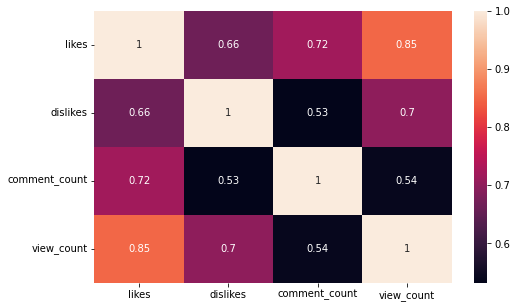

In [9]:
mat = df[['likes', 'dislikes', 'comment_count', 'view_count']].corr()

plt.figure(figsize=(8,5))
sns.heatmap(mat,annot=True)

As you can see all the 4 features which are not given are highly correlated to each other. So, it will not a create issue, also it doesn't make sense.

## Unique Values count

In [10]:
col_uniques = dict()
for col in df.columns:
    col_uniques[col] = len(df[col].unique())
    print(col + ":" + str(len(df[col].unique())))
    
df_col_uniques = pd.DataFrame(col_uniques, index=[0])

video_id:16969
title:17321
publishedAt:16692
channelId:4563
channelTitle:4632
categoryId:15
trending_date:461
tags:12891
view_count:90915
likes:71880
dislikes:12805
comment_count:25556
thumbnail_link:16969
comments_disabled:2
ratings_disabled:2
description:17704
id:92275
duration_seconds:2328
has_thumbnail:2
target:91831


This gives a brief idea of how many unique values are present at each column. The id column has all values unique. Rest have duplicates in it. 

In [11]:
df_col_uniques = df_col_uniques.drop(['video_id', 'id', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'view_count', 'target'], axis=1)
fig = px.bar(df_col_uniques)
fig.show()

### Counts of w.r.t Category Id 

In [12]:
df_cat_val_cnt = pd.DataFrame()
df_cat_val_cnt['categoryId'] = df['categoryId'].astype('str')
px.bar(pd.value_counts(df_cat_val_cnt['categoryId']))

In [13]:
gb_likes = df.groupby('categoryId')['likes']
gb_views = df.groupby('categoryId')['view_count']

df_groupby_cat = pd.DataFrame()
df_groupby_cat['gb_likes'] = gb_likes.median()
df_groupby_cat['gb_views'] = gb_views.median()
df_groupby_cat.index = df_groupby_cat.index.astype('str')
px.bar(df_groupby_cat, title="The likes-views w.r.t Category ")

In [14]:
df_cat_l_v_r = pd.DataFrame()
df_cat_l_v_r['l/v'] = gb_likes.median()/gb_views.median()
df_cat_l_v_r.index = df_cat_l_v_r.index.astype('str')
px.bar(df_cat_l_v_r['l/v'])

Here median is used as using mean can be misleading. This shows that, the category 23 has very high likes per view ratio which has descent number of samples. And though the category 29 has resonably high likes/views ration the number of samples are too low i.e 83. So, we cannot infer that category 29 is best for getting likes. On the other hand the Category 10,23 have high views also has high likes to view ratio. 

In [15]:
px.bar(pd.value_counts(df['has_thumbnail']), title="Thumbnail count plot")

In [16]:
px.box(df['target'], color=df['has_thumbnail'], title="Thumbnail boxplot ")

In [17]:
px.bar(pd.value_counts(df['comments_disabled']), title="Comments Disabled counts ")

In [18]:
px.box(df['target'], color=df['comments_disabled'],  title="Comments Disabled Box plot")

From the above plots it is clear that keep comments on helps the video to get better reach/likes. Also, most of the data has comments enabled. Adding thumbnails definelty helps to boost the reach/likes. 

<a id="feature-engineering-1"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Feature Engineering - 1</h1></center>

Here Feature Engineering is applied to the Tabular data
1. Utilizing Time and Date 
2. Using Groupby Funtions and basic statistics

## Utilizing the Date and Time

In [19]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y-%m-%d')
df['publishdate'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%d')
df['publishdate'] = pd.to_datetime(df['publishdate'].dt.date)
df['publish_date_days_since_start'] = (df['trending_date']-df['publishdate']).dt.days

df['publish_date_day_of_week'] = df['publishedAt'].dt.dayofweek
df['publish_date_year'] = df['publishedAt'].dt.year
df['publish_date_month'] = df['publishedAt'].dt.month
df['publish_date_week'] = df['publishedAt'].dt.isocalendar().week  
df['publish_date_time_hour'] = df['publishedAt'].dt.hour
df['publish_date_time_minute'] = df['publishedAt'].dt.minute

## Applying the basic statistics to each channel

In [20]:
df['channel_title_mean_views'] = df.groupby('channelTitle')['view_count'].transform('mean')
df['channel_title_max_views'] = df.groupby('channelTitle')['view_count'].transform('max')
df['channel_title_min_views'] = df.groupby('channelTitle')['view_count'].transform('min')
df['channel_title_median_views'] = df.groupby('channelTitle')['view_count'].transform('median')

df['channel_title_mean_likes'] = df.groupby('channelTitle')['likes'].transform('mean')
df['channel_title_max_likes'] = df.groupby('channelTitle')['likes'].transform('max')
df['channel_title_min_likes'] = df.groupby('channelTitle')['likes'].transform('min')
df['channel_title_median_likes'] = df.groupby('channelTitle')['likes'].transform('median')

df['channel_title_mean_dislikes'] = df.groupby('channelTitle')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channelTitle')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channelTitle')['dislikes'].transform('min')
df['channel_title_medain_dislikes'] = df.groupby('channelTitle')['dislikes'].transform('median')

df['channel_title_mean_comments'] = df.groupby('channelTitle')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channelTitle')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channelTitle')['comment_count'].transform('min')
df['channel_title_median_comments'] = df.groupby('channelTitle')['comment_count'].transform('median')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   video_id                       92275 non-null  object             
 1   title                          92275 non-null  object             
 2   publishedAt                    92275 non-null  datetime64[ns, UTC]
 3   channelId                      92275 non-null  object             
 4   channelTitle                   92275 non-null  object             
 5   categoryId                     92275 non-null  int64              
 6   trending_date                  92275 non-null  datetime64[ns]     
 7   tags                           92275 non-null  object             
 8   view_count                     92275 non-null  int64              
 9   likes                          92275 non-null  int64              
 10  dislikes              

<a id="tabular-exploration-2"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">More Tabular EDA</h1></center>

In [22]:
px.histogram(df['publish_date_day_of_week'], nbins=10).update_layout(
    xaxis_title="Day of the week", yaxis_title="Counts of the published videos"
)

As per the plot, most of the videos are published on day0,day1,day2,day4,day6 which most likely to be Monday, Tuesday, Wednusday, Friday, Sunday. 

In [23]:
px.histogram(df['publish_date_time_hour'], nbins=30).update_layout(
    xaxis_title="Hour in UTC", yaxis_title="Counts of the published videos"
)

In [24]:
px.scatter(df, x='publish_date_time_hour', y='view_count', color='view_count')

The above data conveys that the views are more likely to highest if the video is published round 3:00 UST , 4:00 UST and 7:00, 21:00, 23:00, 0:00 UST. 

<a id="image-exploration"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Image Exploration</h1></center>

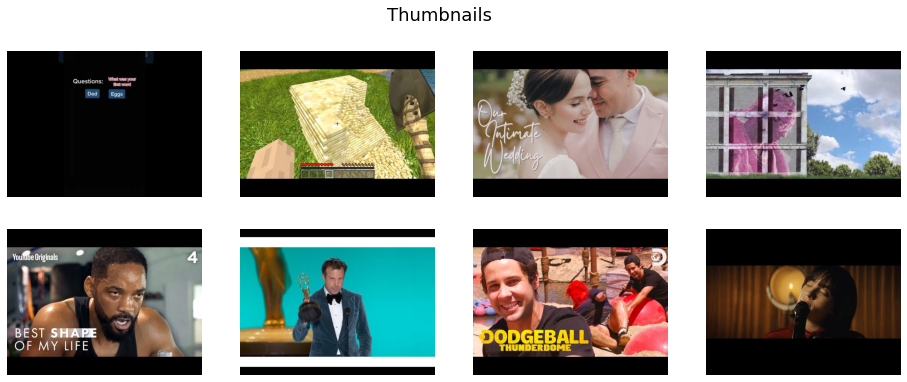

In [25]:
get_image('../input/kaggle-pog-series-s01e01/thumbnails', 8)

The Images here are wide spread and we need extract usefull information for the prediction purpose. One of the approach is to train a custom Neural network and get the last layer vectors for the further operation. As the images are not for recognition, Imagenet based pretrained models cant be used as it is designed for the classification. Also, CNN focuses on the perticular aspect of the image. Hence using the transformer based models can be used for this purpose. 

<a id="text-exploration"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Text Exploration</h1></center>

In [26]:
df.head(1)

video_id                               title               publishedAt  \
0  3C66w5Z0ixs  I ASKED HER TO BE MY GIRLFRIEND... 2020-08-11 19:20:14+00:00   

                  channelId channelTitle  categoryId trending_date  \
0  UCvtRTOMP2TqYqu51xNrqAzg     Brawadis          22    2020-08-12   

                                                tags  view_count   likes  ...  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908  ...   

   channel_title_min_likes  channel_title_median_likes  \
0                    68090                    138100.0   

  channel_title_mean_dislikes  channel_title_max_dislikes  \
0                 7642.771429                       15928   

   channel_title_min_dislikes channel_title_medain_dislikes  \
0                        1175                        4807.0   

  channel_title_mean_comments  channel_title_max_comments  \
0                25879.371429                       45574   

   channel_title_min_comments  channel_title_median_comments  
0                        5131                        31021.0  

[1 rows x 44 columns]

### Operations on title Feature

In [27]:
df['title']

0                       I ASKED HER TO BE MY GIRLFRIEND...
1        Apex Legends | Stories from the Outlands – “Th...
2        I left youtube for a month and THIS is what ha...
3        XXL 2020 Freshman Class Revealed - Official An...
4        Ultimate DIY Home Movie Theater for The LaBran...
                               ...                        
92270                                 thanks for 5 million
92271    Mrs. Rogers done F’ed up😅 #shorts #story #come...
92272                  MY NEW KITCHEN REVEAL!!!!! EXCITING
92273    Using Reverse Psychology To Get ANYTHING You Want
92274      Squid Games In Real Life… BUT it’s ONLY GIRLS!!
Name: title, Length: 92275, dtype: object

In [28]:
def get_words_cnt(df):
    words_cnt = []
    for i in df:
        words_cnt.append(len(i.split(' ')))
    return words_cnt

px.histogram(get_words_cnt(df['title'])).update_layout(
    xaxis_title="Number of Words in Title", yaxis_title="Counts"
)

In [29]:
def get_unique_words(df):
    unq = set()
    for i in df:
        for j in i.split(' '):
            unq.add(j)
    return unq

print("Total Unique words:", len(get_unique_words(df['title'])))

Total Unique words: 32034


### Operation on Tags Feature

In [30]:
df['tags']

0        brawadis|prank|basketball|skits|ghost|funny vi...
1        Apex Legends|Apex Legends characters|new Apex ...
2        jacksepticeye|funny|funny meme|memes|jacksepti...
3        xxl freshman|xxl freshmen|2020 xxl freshman|20...
4        The LaBrant Family|DIY|Interior Design|Makeove...
                               ...                        
92270    danny gonzalez|funny|commentary|comedy|react|r...
92271                                               [None]
92272                                             10-19-21
92273                                               [None]
92274    Lizzy Capri|lizzy|Team RAR|Carter Sharer|squid...
Name: tags, Length: 92275, dtype: object

In [31]:
# To handle [None] we need to create a operation as following
def extract_tags(df):
    none_cnt = 0
    sum_arr = []
    for i in df:
        if i.split('|')==['[None]']:
            none_cnt+=1
            sum_arr.append(0)
        else:
            sum_arr.append(len(i.split('|')))
    print("[None] count:", none_cnt)
    return sum_arr

def get_unique(df):
    unq = set()
    for i in df:
        for j in i.split('|'):
            unq.add(j)
    return unq
        
px.histogram(extract_tags(df['tags']))

[None] count: 13590


In [32]:
print("Total Unique Tags:", len(get_unique(df['tags'])))

Total Unique Tags: 114599


<a id="feature-engineering-2"></a>
<center><h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gold; border:0; padding:10px; color:black' role="tab" aria-controls="home">Feature Engineering - 2</h1></center>

### Feature Engineering of the Image and text 
We can move ahead with following methods for the feature extraction and making use of those features for the process
1. Image to vector (ViT) for the thumbnail images
2. Text to vector (BERT) for the description
3. Words count for Tags

## Image to Vector

In [33]:
# Using the Vision Transformer from Huggingface 

def get_image_vectors(img_path, model_version="google/vit-base-patch16-224-in21k"):
    image = Image.open(img_path)

    feature_extractor = ViTFeatureExtractor.from_pretrained(model_version)
    model = ViTModel.from_pretrained(model_version)

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    pool_output = outputs.pooler_output
    return pool_output


In [34]:
get_image_vectors('../input/kaggle-pog-series-s01e01/thumbnails/--40TEbZ9Is.jpg').shape

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

torch.Size([1, 768])

Either we can use this directly or we can further reduce the dimentions using PCA, Autoencoders etc. These vectors will be further used in the Model training 

## Text to Vector

As we need a model which can handle multiple languages, we can use one of the multilingual model provided by the sentence-transformers library. The Vector generated by this will be further used in the Model Training

In [35]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
sentences = [df['description'][0]]

model.encode(sentences).shape

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 384)

Using the extract_tags to get the count of the tags used  

In [36]:
df['tags_count'] = extract_tags(df['tags'])
df.head(3)

[None] count: 13590


video_id                                              title  \
0  3C66w5Z0ixs                 I ASKED HER TO BE MY GIRLFRIEND...   
1  M9Pmf9AB4Mo  Apex Legends | Stories from the Outlands – “Th...   
2  J78aPJ3VyNs  I left youtube for a month and THIS is what ha...   

                publishedAt                 channelId   channelTitle  \
0 2020-08-11 19:20:14+00:00  UCvtRTOMP2TqYqu51xNrqAzg       Brawadis   
1 2020-08-11 17:00:10+00:00  UC0ZV6M2THA81QT9hrVWJG3A   Apex Legends   
2 2020-08-11 16:34:06+00:00  UCYzPXprvl5Y-Sf0g4vX-m6g  jacksepticeye   

   categoryId trending_date  \
0          22    2020-08-12   
1          20    2020-08-12   
2          24    2020-08-12   

                                                tags  view_count   likes  ...  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908  ...   
1  Apex Legends|Apex Legends characters|new Apex ...     2381688  146739  ...   
2  jacksepticeye|funny|funny meme|memes|jacksepti...     2038853  353787  ...   

   channel_title_median_likes  channel_title_mean_dislikes  \
0                    138100.0                  7642.771429   
1                    157288.0                  2204.630332   
2                    238462.5                  1528.946429   

  channel_title_max_dislikes  channel_title_min_dislikes  \
0                      15928                        1175   
1                       4912                         692   
2                       4666                         399   

   channel_title_medain_dislikes channel_title_mean_comments  \
0                         4807.0                25879.371429   
1                         2081.0                13719.563981   
2                         1049.0                30869.669643   

  channel_title_max_comments  channel_title_min_comments  \
0                      45574                        5131   
1                      27451                        3587   
2                     207849                        3978   

   channel_title_median_comments  tags_count  
0                        31021.0          15  
1                        12425.0          25  
2                        18009.5          30  

[3 rows x 45 columns]